# 4.2.5 Boston Marathon Challenge

<em>From the challenge:</em>

<blockquote>Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.</blockquote>

Data is from [here](https://github.com/llimllib/bostonmarathon)

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from time import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

from sklearn.metrics import classification_report


In [2]:
df = pd.read_csv('/Users/gemma/Documents/data science/DS Bootcamp/bostonmarathon_2014_results.csv')

df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [3]:
df.dtypes

10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object

In [4]:
# trying to figure out what ctz is compared to country ? 
#df.iloc[:,9:].sort_values('ctz', na_position='last').head(10)

In [5]:
# reordering cols bc i want the races to be in order of distance

df = df[['5k','10k','20k','half','25k','30k','35k','40k','official','overall','pace',
         'name','division','gender','age','bib','genderdiv', 'ctz','state', 'country','city']]

In [6]:
#df = df[['mean', 4,3,2,1]]

#['10k','name','division','25k','gender','age','official','bib',
# 'genderdiv', 'ctz','35k','overall','pace','state', '30k','5k','half','20k',
# 'country','city','40k']

toconvert = ['10k','25k','35k', '30k','5k','half','20k','40k']

In [7]:
for thing in toconvert:
    df[thing] = pd.to_numeric(df[thing], errors='coerce')

In [8]:
# making a binary marker for gender - 1 = male, 0 = female

df['gender_bin'] = np.where(df['gender'] == 'M', 1, 0)

I'm going to drop much of the categorical data.

In [9]:
df = df.drop(['name','gender','bib','ctz','state','city'], axis=1)

I want to split up "country" based on the number of participants from that country, and potentially use that number instead of binarizing country.

In [11]:
this = df['country'].value_counts()

print(np.mean(this), np.std(this), np.max(this))

410.05128205128204 3066.8041157774733 27233


USA    27233
CAN     2175
GBR      346
ITA      212
MEX      205
GER      182
JPN      175
AUS      124
IRL      119
FRA      115
ESP       89
BRA       87
SWE       66
SUI       62
KOR       60
NED       54
HKG       53
DEN       50
CHN       42
COL       40
CHI       29
FIN       28
ISL       28
BEL       27
SIN       23
AUT       22
NOR       21
VEN       19
RSA       19
BER       18
       ...  
TUR        4
PHI        4
LUX        4
CZE        4
HUN        3
DOM        3
ECU        3
PAN        3
UKR        3
EGY        2
ROU        2
BAH        2
ESA        2
THA        2
QAT        2
TRI        1
BRN        1
MAR        1
TAN        1
CRO        1
VGB        1
BLR        1
LIE        1
URU        1
EST        1
INA        1
CAY        1
BOL        1
ZIM        1
BAR        1
Name: country, Length: 78, dtype: int64

In [12]:
this.value_counts().sort_index()

1        15
2         6
3         5
4         6
6         2
7         2
8         1
9         2
12        1
15        3
16        1
17        2
18        3
19        2
21        1
22        1
23        1
27        1
28        2
29        1
40        1
42        1
50        1
53        1
54        1
60        1
62        1
66        1
87        1
89        1
115       1
119       1
124       1
175       1
182       1
205       1
212       1
346       1
2175      1
27233     1
Name: country, dtype: int64

In [13]:
df = df.join(this, on='country', how='left', rsuffix='_count', sort=False)

# from stack exchange also could have done this whole thigng like this:
# df['Counts'] = df.groupby(['Color'])['Value'].transform('count')

# OR 
# df['Count_Column'] = df['Color'].map(df['Color'].value_counts())

In [14]:
df.head()

,5k,10k,20k,half,25k,30k,35k,40k,official,overall,pace,division,age,genderdiv,country,gender_bin,country_count
0,8.02,17.37,37.65,39.72,47.67,59.18,71.40,80.43,85.25,8,3.27,8,47,8,JPN,1,175
1,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,138.95,21,5.30,1,33,1,KEN,0,12
2,7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60,1,3.08,1,41,1,RSA,1,19
3,16.20,32.57,65.83,69.47,82.43,99.33,116.37,132.95,140.58,27,5.37,3,24,3,ETH,0,6
4,8.02,17.12,36.58,38.60,46.37,57.03,67.83,76.72,81.23,2,3.10,2,40,2,JPN,1,175


In [16]:
#df['USA'] = np.where(df['country'] == 'USA', 1, 0)
#df['Canada'] = np.where(df['country'] == 'Canada' ,1, 0)


#50 to 350, 
#less than 50 and greater than 10, 
#less than 10

#df['50_to_350p'] = np.where(np.logical_and(df['country_count']>=50 ,df['country_count'] < 350), 1, 0)
#df['10+'] = np.where(np.logical_and(df['country_count']>=10 ,df['country_count'] < 50), 1, 0)
#df['lessthan10'] = np.where(df['country_count'] < 10, 1, 0)


In [17]:
#df.head()

In [15]:
df.isnull().sum()

df.fillna(0, inplace=True)

In [16]:
df = df.drop('country',1)

Let's look at the correlation matrix and drop features with over 90% correlation.

In [17]:
df.corr()

,5k,10k,20k,half,25k,30k,35k,40k,official,overall,pace,division,age,genderdiv,gender_bin,country_count
5k,1.000000,0.963261,0.928090,0.924685,0.766526,0.900208,0.880755,0.847863,0.875720,0.860468,0.875903,0.454344,0.156280,0.763285,-0.258461,0.104444
10k,0.963261,1.000000,0.953914,0.950589,0.778816,0.926809,0.906092,0.871696,0.898462,0.874791,0.898558,0.457038,0.163271,0.775604,-0.262733,0.101612
20k,0.928090,0.953914,1.000000,0.961813,0.806909,0.960423,0.937077,0.903718,0.922466,0.888320,0.922885,0.467880,0.160633,0.788970,-0.261121,0.096910
half,0.924685,0.950589,0.961813,1.000000,0.782167,0.951619,0.933299,0.895846,0.925348,0.883483,0.925328,0.467029,0.158288,0.786785,-0.254099,0.097321
25k,0.766526,0.778816,0.806909,0.782167,1.000000,0.801507,0.791223,0.805845,0.774548,0.796723,0.776414,0.430179,0.135917,0.709651,-0.229755,0.088700
30k,0.900208,0.926809,0.960423,0.951619,0.801507,1.000000,0.975266,0.943563,0.959883,0.913311,0.960339,0.492966,0.153044,0.821153,-0.241531,0.095410
35k,0.880755,0.906092,0.937077,0.933299,0.791223,0.975266,1.000000,0.960374,0.975911,0.929613,0.976852,0.504534,0.153918,0.843499,-0.226927,0.093867
40k,0.847863,0.871696,0.903718,0.895846,0.805845,0.943563,0.960374,1.000000,0.962319,0.932033,0.964962,0.508014,0.156482,0.853469,-0.210695,0.091431
official,0.875720,0.898462,0.922466,0.925348,0.774548,0.959883,0.975911,0.962319,1.000000,0.954233,0.999897,0.515368,0.166440,0.878360,-0.204402,0.093113
overall,0.860468,0.874791,0.888320,0.883483,0.796723,0.913311,0.929613,0.932033,0.954233,1.000000,0.954765,0.514493,0.201129,0.909206,-0.246634,0.086182


It looks like I can keep just one of these:

5k, 10k, 20k, half, 30k

I will keep 5k.

It looks like I can also drop 2 of these:

official, overall, pace

If I keep official, it looks like I should also drop:

30k, 35k, 40k

In [18]:
df = df.drop(['10k', '20k', 'half', '30k', 'overall', 'pace', '30k', '35k', '40k'], 1)

In [19]:
df.corr()

,5k,25k,official,division,age,genderdiv,gender_bin,country_count
5k,1.000000,0.766526,0.875720,0.454344,0.156280,0.763285,-0.258461,0.104444
25k,0.766526,1.000000,0.774548,0.430179,0.135917,0.709651,-0.229755,0.088700
official,0.875720,0.774548,1.000000,0.515368,0.166440,0.878360,-0.204402,0.093113
division,0.454344,0.430179,0.515368,1.000000,-0.577256,0.470752,-0.125786,0.150054
age,0.156280,0.135917,0.166440,-0.577256,1.000000,0.306829,0.208802,-0.153566
genderdiv,0.763285,0.709651,0.878360,0.470752,0.306829,1.000000,0.166793,0.040822
gender_bin,-0.258461,-0.229755,-0.204402,-0.125786,0.208802,0.166793,1.000000,-0.100223
country_count,0.104444,0.088700,0.093113,0.150054,-0.153566,0.040822,-0.100223,1.000000


dividing into training and test sets with gender being the y, and normalizing x

In [20]:
X = normalize(df.drop('gender_bin',1))
y = df['gender_bin']

In [21]:
X_pca = PCA(3).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_pca,
    y,
    test_size=0.2,
    random_state=60)

Running stratified k fold because the training and testing sets are too large for my computer to handle running affinity propagation

In [56]:
skf = StratifiedKFold(n_splits=2)

skf.get_n_splits(X_pca, y)

2

In [57]:

for train_index, test_index in skf.split(X_pca, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train2, X_test2 = X[train_index], X[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]


TRAIN: [10516 10517 10518 ... 31981 31982 31983] TEST: [    0     1     2 ... 18574 18575 18576]
TRAIN: [    0     1     2 ... 18574 18575 18576] TEST: [10516 10517 10518 ... 31981 31982 31983]


In [58]:
len(X_train2)

15993

using $k$-means

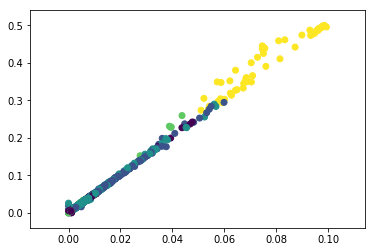

Time: 2.655435085296631 seconds 
Comparing k-means clusters against the data:
gender_bin     0     1
row_0                 
0           2168  2914
1            301   420
2            396  1145
3           4297  4294
4             22    36


In [59]:
# with kmeans

start = time()
# Calculate predicted values.
y_pred = KMeans(n_clusters=5, random_state=0).fit_predict(X_train2)

# Plot the solution.
plt.scatter(X_train2[:, 0], X_train2[:, 1], c=y_pred)
plt.show()

kmean_duration = time()-start

print('Time: {} seconds '.format(kmean_duration))
      
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
      
kmean_accuracy = pd.crosstab(y_pred, y_train2)
print(kmean_accuracy)
      
#print(classification_report(y, y_pred))

In [60]:

from sklearn import metrics
    
metrics.adjusted_rand_score(y_train2, y_pred)

0.0004985427662067465

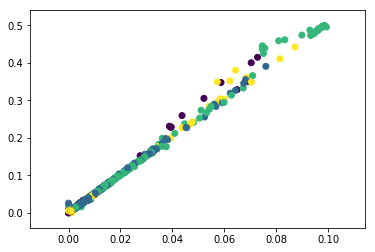

Time: 1.5146188735961914 seconds 
Comparing k-means clusters against the data:
gender_bin     0     1
row_0                 
0           4336  4346
1            397  1152
2            316   436
3           2135  2875
             precision    recall  f1-score   support

          0       0.50      0.60      0.55      7184
          1       0.74      0.13      0.22      8809
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         0

avg / total       0.63      0.34      0.37     15993



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [61]:
# with kmeans

start = time()
# Calculate predicted values.
y_pred = KMeans(n_clusters=4, random_state=0).fit_predict(X_train2)

# Plot the solution.
plt.scatter(X_train2[:, 0], X_train2[:, 1], c=y_pred)
plt.show()

kmean_duration = time()-start

print('Time: {} seconds '.format(kmean_duration))
      
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
      
kmean_accuracy = pd.crosstab(y_pred, y_train2)
print(kmean_accuracy)
      

#blob1.append(kmean_duration)

print(classification_report(y_train2, y_pred))

mean shift

Duration: 0.5819451808929443 seconds
Number of estimated clusters: 14


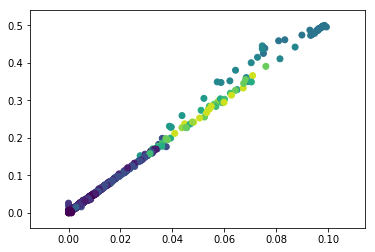

Comparing the assigned categories to the ones in the data:
col_0         0    1    2    3    4   5   6   7   8   9   10  11  12  13
gender_bin                                                              
0           6433  169  231  120  189  12   5   2   4   3   3   4   8   1
1           7166  715  440  262  176  15   7   5   4   8   6   2   3   0


In [62]:
from sklearn.cluster import MeanShift, estimate_bandwidth

start = time()

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train2, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train2)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers2 = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print('Duration: {} seconds'.format(time()-start))
print("Number of estimated clusters: {}".format(n_clusters_))

plt.scatter(X_train2[:, 0], X_train2[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train2,labels))

In [63]:
metrics.adjusted_rand_score(labels, y_train2)

-0.00808960702678816

spectral clustering

Duration: 950.8766207695007 seconds


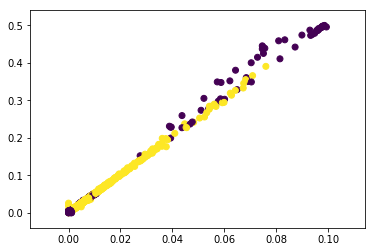

Comparing the assigned categories to the ones in the data:
col_0          0     1
gender_bin            
0           6474   710
1           7216  1593


In [64]:
from sklearn.cluster import SpectralClustering

start = time()

# We know we're looking for three clusters.
n_clusters=2

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train2)

#Predicted clusters.
predict=sc.fit_predict(X_train2)

print('Duration: {} seconds'.format(time()-start))

#Graph results.
plt.scatter(X_train2[:, 0], X_train2[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train2,predict))

In [65]:
metrics.adjusted_rand_score(predict, y_train2)

-0.005213893305783393

affinity propagation

In [ ]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [ ]:

skf = StratifiedKFold(n_splits=20)

skf.get_n_splits(X_pca, y)

for train_index, test_index in skf.split(X_pca, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train2, X_test2 = X[train_index], X[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]

    start = time()
    af = AffinityPropagation().fit(X_train2)
    print('Done')

    # Pull the number of clusters and cluster assignments for each data point.
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    labels = af.labels_

    print('Duration: {} seconds'.format(time()-start))
    print('Estimated number of clusters: {}'.format(n_clusters_))

TRAIN: [  944   945   946 ... 31981 31982 31983] TEST: [   0    1    2 ... 7695 7705 7709]


In [ ]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train2[cluster_centers_indices[k]]
    plt.plot(X_train2[class_members, 0], X_train2[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train2[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()